## George Chen (5831-4381-96)
## 570 HW2

In [108]:
! pip install graphviz
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)
import graphviz as gr


## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases


# Example:
Covariates may affect study results. For example, if we conduct an experiment to see how drought tolerant corn plants are. Drought level is the actual "treatment", but it's not the only factor that affects plant performance: size is a known factor that affects tolerance levels, so we can run plant size as a covariate. In this place, if we do not consider the effect of covariates, we have drought level as the "treatment" variable and tolerance level as the dependent variable.

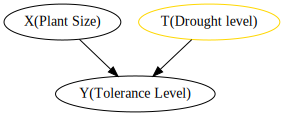

In [109]:
g = gr.Digraph()
g.edge("X(Plant Size)", "Y(Tolerance Level)"),g.edge("T(Drought level)", "Y(Tolerance Level)")
g.node("T(Drought level)", color="gold")
g

## a. Experiments with no covariates in the DGP

$y_i = \tau*T_i+10*x_i+e_i$

In [110]:
class MC1a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(2,1,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + 3*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [111]:
np.random.seed(3)
n = 500
T = np.random.binomial(1, 0.5, n)
X = np.random.normal(2,1,n)
Y = np.random.normal(1 + 1*T + 3*X, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

In [112]:
# N=100
mcSim_100 = MC1a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC1a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,0.993908,0.964139
RMSE,5.589603,5.655322
treatment effect,0.993908,0.964139


## b. Experiments with all covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [113]:
class MC1b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(2,1,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]


In [114]:
# N=100
mcSim_100 = MC1b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,3,100,1)
# N=1000
mcSim_1000 = MC1b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,3,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,0.964352,0.979184
RMSE,4.789234,4.858755
treatment effect,0.962739,0.977406


## 2. Simulate a DGP with a confounder (common cause)

# Example:
Obesity may cause cardiovascular disease. Studies have shown that obese people are 1.79 times more likely to develop cardiovascular disease than non-obese people. However, it is known that the risk of cardiovascular disease also increases with age, and the BMI index, which is a criterion for judging obesity, also tends to increase with age.\
See: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_multivariable/BS704_Multivariable2.html

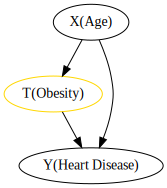

In [115]:
g = gr.Digraph()
g.edge("T(Obesity)", "Y(Heart Disease)")
g.edge("X(Age)", "T(Obesity)")
g.node("T(Obesity)",color = "gold")
g.edge("X(Age)", "Y(Heart Disease)")
g

# a. You fail to control for the confounder

In [116]:
np.random.seed(3)
n = 500
# generate covariate
X = np.random.normal(10,2,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**2), n)
# generate outcome
Y = np.random.normal(1 - 1*T + 1*X, 5).astype(int)
data2 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data2.to_csv("data2.csv", index=False)

In [117]:
class MC2a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(10,2,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [118]:
# N=100
mcSim_100 = MC2a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,-1,100,1)
# N=1000
mcSim_1000 = MC2a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,-1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,N=100,N=1000
bias,NaN,-1.893386
RMSE,5.285531,5.330851
treatment effect,-1.284023,-1.893386


# b. You do control for the confounder

In [119]:
class MC2b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(10,2,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [120]:
# N=100
mcSim_100 = MC2b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,-1,1,100,1)
# N=1000
mcSim_1000 = MC2b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,-1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,N=100,N=1000
bias,NaN,-1.879627
RMSE,4.896341,4.958229
treatment effect,-0.532435,-0.962018


# 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

# Example:
Many of our college students publish questionnaires on the Internet for coursework, graduation thesis, or so-called academic research activities, and then transfer to the space and circle of friends. This survey method itself has the problem of sample selection, because there are still a large number of The crowd is not in your circle of friends (your friend list is all your classmates and friends), and there are a large number of people who do not use the Internet at all, or simply do not see the questionnaires you posted.

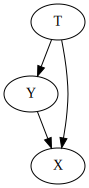

In [121]:
g = gr.Digraph()
g.edge("T","Y")
g.edge("T","X")
g.edge("Y", "X")
g

# a. You control for the variable in between the path from cause to effect

In [122]:
class MC3a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 2*T, 1).astype(int)
        X = np.random.normal(np.mean(T)*np.mean(Y),10,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]
    

In [123]:
# N=100
mcSim_100 = MC3a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,2,1,100,1)
# N=1000
mcSim_1000 = MC3a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,2,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/Users/georgechen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,1.844323,1.843607
RMSE,0.923106,0.938419
treatment effect,1.843925,1.843626


# b. You do not control for the variable in between the path from cause to effect

In [126]:
class MC3b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 2*T, 1).astype(int)
        X = np.random.normal(np.mean(T)*np.mean(Y),10,n)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [128]:
# N=100
mcSim_100 = MC3b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,2,100,1)
# N=1000
mcSim_1000 = MC3b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,2,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,1.853884,1.841921
RMSE,0.927913,0.939026
treatment effect,1.853884,1.841921
